# Combining Color Histograms and HOG
In this notebook, I'll try out some different strategies for combining color histogram and HOG features for classification. There are several options for combining the two, including combining the feature vectors into one or having two steps in the classification process.

Before getting into that, I'll follow Kevin's suggestion and try clustering my roof samples to see if there are clear boundaries between different subclasses of roofs. If there are, then maybe I should have different classifiers to identify each subclass.

In [22]:
from utils import *
from features import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn import decomposition

%matplotlib inline

In [2]:
# Import image data
csv_in = '../data/imageData.csv'
hists, labels, le = import_image_data(csv_in)

In [3]:
# Get only roof data
indices = np.where(labels==1)
hists = hists[indices[0],:]
labels = labels[indices[0]]

In [4]:
# Calculate the 1st 2 PCA components
pca = decomposition.PCA(n_components=2)
pca.fit(hists)
X = pca.transform(hists)

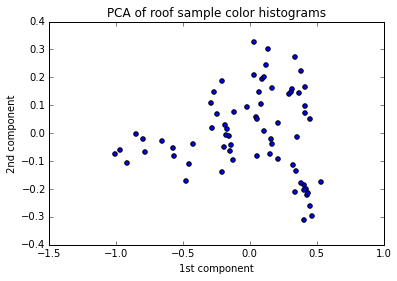

In [5]:
# Plot PCA decomposition of roof samples only
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.title('PCA of roof sample color histograms')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

There doesn't seem to be a real obvious way to cluster the roofs in our sample training set - let's come back to this later.

## Saving training data
The first thing that we need to do is compute color histograms, HOG features, and gradient magnitude histograms and store them in a pandas dataframe to be written to csv. I'd like to automate this processs so that I can just give the function a directory containing all of my training samples and it'll figure out which classes are there by looking at the names of the folders.

In [6]:
import glob
import os

In [9]:
sample_dir = '../images/samples/'
csv_out = '../data/all_image_data.csv'

In [30]:
# Setting column names of dataframe
columns = ['class', 'imageID', 'filename', 'width', 'height']
columns = columns + ['color' + str(i + 1) for i in range(48)]
columns = columns + ['hog' + str(i + 1) for i in range(9)]
columns = columns + ['mag' + str(i + 1) for i in range(16)]

In [31]:
# Create data frame for image data
image_data = pd.DataFrame(columns=columns)

In [32]:
# Keep track of total images processed
count_total = 0
start_time = time()
# Search sample directory for all sample class subdirectories
for class_dir in glob.iglob(sample_dir + '*'):
    # Get class name
    class_name = os.path.basename(class_dir)
    # Add data for each image in class subdirectory
    count_class = 0
    for image_path in glob.iglob(class_dir + '/*.png'):
        # Get image basename with extension
        image_fn = os.path.basename(image_path)
        # Get image ID
        imageID = image_fn[:-4]
        # Read in image and get dimensions
        image = cv2.imread(image_path)
        h, w = image.shape[:2]
        # Calculate color histogram
        color = calc_color_hist(image)
        color = np.transpose(color)
        # Create color histogram dataframe
        color_df = pd.DataFrame(color)
        col_names = list(color_df.columns.values)
        new_names = ['color' + str(i + 1) for i in col_names]
        color_df.columns = new_names
        # Calculate hog and gradient magnitude features
        (hog, hog_bins, mag, mag_bins, max_mag) = compute_hog(image)
        hog = hog.reshape(1, hog.size)
        mag = mag.reshape(1, mag.size)
        # Create hog dataframe
        hog_df = pd.DataFrame(hog)
        col_names = list(hog_df.columns.values)
        new_names = ['hog' + str(i + 1) for i in col_names]
        hog_df.columns = new_names
        # Create gradient magnitude dataframe
        mag_df = pd.DataFrame(mag)
        col_names = list(mag_df.columns.values)
        new_names = ['mag' + str(i + 1) for i in col_names]
        mag_df.columns = new_names
        # Create dataframe for image
        img_data = pd.DataFrame({'class': [class_name], 'imageID':\
                                 [imageID], 'filename': [image_fn],\
                                 'width': [w], 'height': [h]})
        img_data = pd.concat([img_data, color_df, hog_df, mag_df],\
                           axis=1)
        # Add new image data to image dataframe and continue indexing
        image_data = image_data.append(img_data, ignore_index=True)
        count_total += 1
        count_class += 1
    # Print update for class
    print 'Processed {} images for {} class.'.format(count_class,\
                                                     class_name)

end_time = time()
print 'Processed {} images total in {} seconds.'.format(count_total,\
                                            (end_time - start_time))

../images/samples/roofs
Processed 70 images for roofs class.
../images/samples/water
Processed 70 images for water class.
../images/samples/vegetation
Processed 70 images for vegetation class.
../images/samples/dirt
Processed 70 images for dirt class.
Processed 280 images total in 34.754201889 seconds.


In [33]:
# Drop rows with duplicated information
image_data.drop_duplicates(['class', 'filename'], inplace=True)
# Reorganize columns
image_data = image_data[columns]
# Writing image data to csv
image_data.to_csv(csv_out)

Right now it takes ~35 seconds to process 280 training samples. Let's put all of this code into one function so that in the future we can easily recompute image data for all of our training samples:

In [196]:
import numpy as np
import pandas as pd
import glob
from time import time
import matplotlib.pyplot as plt
import os

In [197]:
def process_image(image_path, class_name, image_data):
    """
    This function process one image and adds its data to the dataframe
    containing all of the training image data.
    :param image_path: Path to image to process
    :param class_name: Class of image sample
    :param image_data: Dataframe containing training data
    :returns: Dataframe containing new image data
    """
    # Get image basename with extension
    image_fn = os.path.basename(image_path)
    # Get image ID
    imageID = image_fn[:-4]
    
    # Read in image and get dimensions
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    
    # Calculate color histogram
    color = calc_color_hist(image)
    color = np.transpose(color)
    # Create color histogram dataframe
    color_df = pd.DataFrame(color)
    col_names = list(color_df.columns.values)
    new_names = ['color' + str(i + 1) for i in col_names]
    color_df.columns = new_names
    
    # Calculate hog and gradient magnitude features
    (hog, hog_bins, mag, mag_bins, max_mag) = compute_hog(image)
    hog = hog.reshape(1, hog.size)
    mag = mag.reshape(1, mag.size)
    # Create hog dataframe
    hog_df = pd.DataFrame(hog)
    col_names = list(hog_df.columns.values)
    new_names = ['hog' + str(i + 1) for i in col_names]
    hog_df.columns = new_names
    
    # Create gradient magnitude dataframe
    mag_df = pd.DataFrame(mag)
    col_names = list(mag_df.columns.values)
    new_names = ['mag' + str(i + 1) for i in col_names]
    mag_df.columns = new_names
    
    # Create dataframe for image
    img_data = pd.DataFrame({'class': [class_name], 'imageID':\
                             [imageID], 'filename': [image_fn],\
                             'width': [w], 'height': [h]})
    img_data = pd.concat([img_data, color_df, hog_df, mag_df],\
                       axis=1)
    
    # Add new image data to image dataframe and continue indexing
    return image_data.append(img_data, ignore_index=True)

In [198]:
def store_image_data(image_dir, csv_out):
    """
    This function goes through each of the class sample directories
    within the samples directory and computes color histogram and HOG
    features for each image within, then writes the data to a csv file
    for later use.
    :param image_dir: Path to the directory containing image samples
    :param csv_out: Path of output csv file containing data
    """
    start_time = time()
    
    # Setting column names of dataframe
    columns = ['class', 'imageID', 'filename', 'width', 'height']
    columns = columns + ['color' + str(i + 1) for i in range(48)]
    columns = columns + ['hog' + str(i + 1) for i in range(9)]
    columns = columns + ['mag' + str(i + 1) for i in range(16)]
    
    # Create data frame for image data
    image_data = pd.DataFrame(columns=columns)
    
    # Keep track of total images processed
    count_total = 0
    
    # Search sample directory for all sample class subdirectories
    for class_dir in glob.iglob(sample_dir + '*'):
        # Get class name
        class_name = os.path.basename(class_dir)
        # Add data for each image in class subdirectory
        count_class = 0
        for image_path in glob.iglob(class_dir + '/*.png'):
            # Add data for each image
            image_data = process_image(image_path, class_name,\
                                       image_data)
            count_total += 1
            count_class += 1
        # Print update for class
        print 'Processed {} images for {} class.'.format(count_class,\
                                                         class_name)
    
    # Drop rows with duplicated information
    image_data.drop_duplicates(['class', 'filename'], inplace=True)
    # Reorganize columns
    image_data = image_data[columns]
    # Writing image data to csv
    image_data.to_csv(csv_out)
    end_time = time()
    print 'Processed {} images total in {} seconds.'.format(count_total,\
                                                (end_time - start_time))

Let's test out the function!

In [199]:
store_image_data(sample_dir, csv_out)

Processed 70 images for roof class.
Processed 70 images for water class.
Processed 70 images for vegetation class.
Processed 70 images for dirt class.
Processed 280 images total in 36.5406188965 seconds.


It works!

### Loading training data
We previously wrote a function that would load in the color histogram data for our training samples from a given csv file. Let's update that function so that it works with our more complete dataset that contains color histogram, hog, and gradient magnitude feature vectors.

In [211]:
def import_image_data(csv_in, display=False):
    """
    This function reads image data from a csv file and returns Numpy
    arrays containing the image features and the image labels so that
    the data is ready for use. It also returns a label encoder so that
    we can go back and forth between class string labels and integer
    encodings.
    :param csv_in: Path of csv file containing image data
    :param display: Print out updates
    :returns: All features vectors, color histogram vectors, HOG vectors,
    gradient magnitude vectors, image labels, and label encoder
    """
    # Loading image data from csv
    image_data = pd.read_csv(csv_in)
    # Need to convert imageIDs to strings (some get converted to ints)
    image_data.imageID = image_data.imageID.astype(str)
    # Drop first column
    image_data.drop('Unnamed: 0', axis=1, inplace=True)
    # Get class labels
    labels = image_data.as_matrix(columns=['class'])
    # Making 2D array into 1D array
    labels = labels.flatten()
    # Encode labels with value between 0 and n_classes-1
    label_encoder = preprocessing.LabelEncoder()
    # dirt = 0, roof = 1, vegetation = 2, water = 3
    label_encoder.fit(labels)
    if display:
        print label_encoder.classes_ # displays the set of classes
    labels = label_encoder.transform(labels)
    if display:
        print 'Got class labels for {} training data points.'.format\
              (labels.shape[0])
    # Get color histograms
    color_columns = ['color' + str(i+1) for i in range(48)]
    colors = image_data.as_matrix(columns=color_columns)
    # Get hog vectors
    hog_columns = ['hog' + str(i+1) for i in range(9)]
    hogs = image_data.as_matrix(columns=hog_columns)
    # Get gradient magnitude vectors
    mag_columns = ['mag' + str(i+1) for i in range(16)]
    mags = image_data.as_matrix(columns=mag_columns)
    # Join into all features vectors
    all_columns = color_columns + hog_columns + mag_columns
    features = image_data.as_matrix(columns=all_columns)
    if display:
        print 'Got feature vectors for {} training data points.'.format\
              (features.shape[0])
    return (features, colors, hogs, mags, labels, label_encoder)

In [12]:
csv_in = '../data/all_image_data.csv'

In [212]:
features, colors, hogs, mags, labels, label_encoder = \
                import_image_data(csv_in, display=True)

['dirt' 'roof' 'vegetation' 'water']
Got class labels for 280 training data points.
Got feature vectors for 280 training data points.


### Classification of samples using all features
Earlier we had tried classifying our sample images using both color histograms and HOG features separately but not with both. We also have a 3rd feature vector now, the gradient magnitudes histogram. Let's try classifying first using color and hog then with all three.

In [22]:
# Features with both color histograms and hog vector
color_hog = np.concatenate((colors, hogs), axis=1)

#### PCA

In [20]:
from sklearn import decomposition

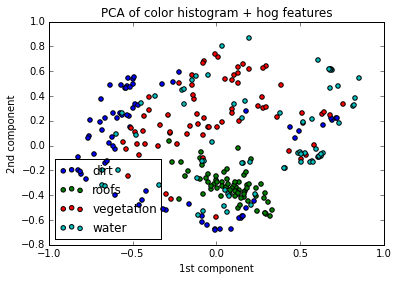

In [23]:
# Calculate the 1st 2 PCA components
pca = decomposition.PCA(n_components=2)
pca.fit(color_hog)
X_pca = pca.transform(color_hog)
# Plot PCA decomposition with 4 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_pca[indices,0], X_pca[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='lower left')
plt.title('PCA of color histogram + hog features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

That looks pretty good! Definitely much better than the hog only PCA and actually very similar to the color histogram PCA. It's possible that the hog features don't add much information here.

Let's see if adding in the gradient magnitudes helps:

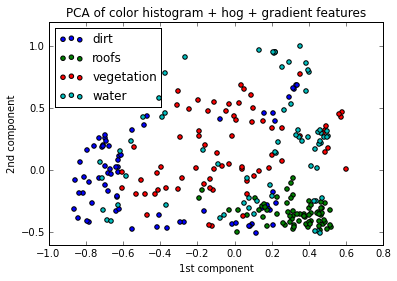

In [30]:
# Calculate the 1st 2 PCA components
pca = decomposition.PCA(n_components=2)
pca.fit(features)
X_pca = pca.transform(features)
# Plot PCA decomposition with 4 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_pca[indices,0], X_pca[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='upper left')
plt.title('PCA of color histogram + hog + gradient features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

This seems to be even better! Things are starting to look more promising...

#### LDA

In [26]:
from sklearn import lda

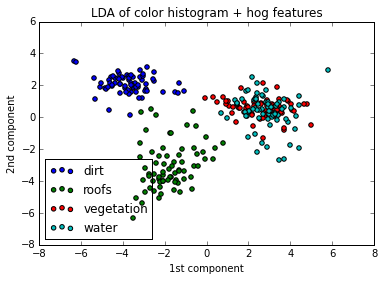

In [31]:
# Projection onto the first 2 linear discriminant components
color_hog2 = color_hog.copy()
color_hog2.flat[::color_hog2.shape[1] + 1] += 0.01 # Make X invertible
X_lda = lda.LDA(n_components=2).fit_transform(color_hog2, labels)
# Plot LDA decomposition with 4 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_lda[indices,0], X_lda[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='lower left')
plt.title('LDA of color histogram + hog features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

Jeez that looks pretty great, maybe even a little better than the color histogram only LDA. Let's try adding in the gradients.

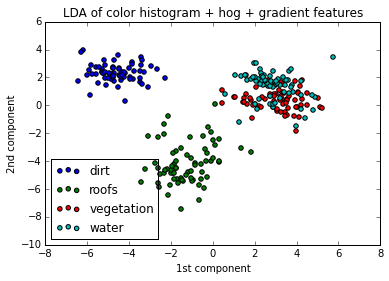

In [32]:
# Projection onto the first 2 linear discriminant components
features2 = features.copy()
features2.flat[::features2.shape[1] + 1] += 0.01 # Make X invertible
X_lda = lda.LDA(n_components=2).fit_transform(features2, labels)
# Plot LDA decomposition with 4 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_lda[indices,0], X_lda[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='lower left')
plt.title('LDA of color histogram + hog + gradient features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

#### kNN

In [33]:
from sklearn import neighbors

In [58]:
# Mix up the data
perm = np.random.permutation(labels.size)
features = features[perm]
color_hog = color_hog[perm]
labels = labels[perm]

In [61]:
# Create and fit a nearest-neighbor classifier on color histograms and hog
n_neighbors = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Train on first 200 out of 280 observations
knn.fit(color_hog[:200], labels[:200])
# Test on observations 201-280
accuracy = knn.score(color_hog[200:], labels[200:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.75


In [62]:
# Create and fit a nearest-neighbor classifier on all features
n_neighbors = 5
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Train on first 200 out of 280 observations
knn.fit(features[:200], labels[:200])
# Test on observations 201-280
accuracy = knn.score(features[200:], labels[200:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.775


It seems like we get comparable accuracy using kNN whether or not we use the gradient magnitude histogram vector. Let's use cross-validation to select the best k for nearest neighbors:

In [63]:
from sklearn import cross_validation

In [94]:
# Cross validation model
folds = 10
kf = cross_validation.KFold(n=features.shape[0], n_folds=folds,\
                            shuffle=True)

In [95]:
# Running cross-validation to pick k
k_min = 1
k_max = 20
accuracies = np.zeros((folds, (k_max - k_min + 1)))
fold = 0
# Iterating through each fold
for train_index, test_index in kf:
    # Increment fold
    fold += 1
    # Choosing training and test set for this fold
    X_train, X_test = features[train_index], features[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
    for k in range(k_min, k_max + 1):
        knn = neighbors.KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, Y_train)
        accuracies[fold-1, k-1] = knn.score(X_test, Y_test)    

In [96]:
# Calculate average accuracy for each value of k
mean_accuracies = np.mean(accuracies, axis=0)
print mean_accuracies

[ 0.95357143  0.89642857  0.9         0.85714286  0.84285714  0.83214286
  0.81428571  0.8         0.80714286  0.79642857  0.78571429  0.78214286
  0.77857143  0.77857143  0.77857143  0.76071429  0.76428571  0.76071429
  0.76071429  0.73571429]


It seems like $k=3$ is pretty consistently getting good classification results on our samples.

## Satellite image roof detection
The previous results looked pretty promising! Maybe we should just try to classify candidates using the full feature vector first and see how it goes. However, in the past we wrote a couple different versions of a `classify_image` function that used color histograms and hog only. Let's clean that code up and write a general function that can classify image patches using whatever features we choose:

In [10]:
image_fn = '../images/test_images/test10.png'
template_fn = '../images/templates/template1.png'
image_data_fn = '../data/all_image_data.csv'

In [11]:
out_fn = '../images/output_images/10_color_only.png'

In [12]:
from utils import *
from skimage.measure import label

def find_markers(image_fn, template_fn, thresh=0.05):
    """
    This function performs template matching on an image with a template
    and thresholds the result, returning the labeled markers and the
    total number of markers.
    :param image_fn: Path of input image
    :param template_fn: Path of template to match
    :param thresh: Threshold value for template matching
    :returns: Labeled markers and number of markers
    """
    # Match template and threshold result
    matched = match_template(image_fn, template_fn)
    threshed = np.copy(matched)
    threshed[np.where(matched > thresh)] = 0
    threshed[np.where(matched <= thresh)] = 1
    
    # Marker labeling
    markers, num_markers = label(threshed, return_num=True)
    return (markers, num_markers)

In [13]:
def find_centroids(markers, num_markers):
    """
    This function finds the centroid for each roof candidate.
    :param markers: Array of pixels corresponding to labeled candidates
    :param num_markers: Number of candidates (+1 for background)
    :returns: Candidate centroids
    """
    centroids = np.zeros((num_markers-1, 2))
    for i in range(num_markers-1):
        location = np.where(markers==(i + 1))
        centroids[i,:] = np.array([location[0].mean(),
                                   location[1].mean()]).round()
    return centroids

In [14]:
def get_training_data(image_data_fn, use_color=True, use_hog=True,
                      use_mag=True):
    """
    This function gets the right training data for the classifier that
    we want to use.
    :param image_data_fn: Path of csv containing training data
    :param use_color: Use color histogram for classification
    :param use_hog: Use histogram of oriented gradients
    :param use_mag: Use gradient magnitudes
    :returns: Training data, training labels, and a label encoder
    """
    # Load training data
    (features, colors, hogs, mags, train_labels, label_encoder) = \
                import_image_data(image_data_fn)
    
    # Getting correct training data
    if use_color and use_hog and use_mag:
        train_data = features
    elif use_color and use_hog:
        train_data = np.concatenate((colors, hogs), axis=1)
    elif use_color and use_mag:
        train_data = np.concatenate((colors, mags), axis=1)
    elif use_hog and use_mag:
        train_data = np.concatenate((hogs, mags), axis=1)
    elif use_color:
        train_data = colors
    elif use_hog:
        train_data = hogs
    elif use_mag:
        train_data = mags
    else:
        print 'Error: No features were specified.'
    
    return (train_data, train_labels, label_encoder)

In [15]:
from features import *

def get_color_vector(image, centroid, color_rad):
    """
    This functions gets the color histogram vector for a candidate in an
    image.
    :param image: Input image
    :param centroid: Centroid of candidate
    :param color_rad: Radius for computing color histogram
    :returns: Color histogram vector (1x48)
    """
    row = centroid[0]
    col = centroid[1]
    # Get candidate patch
    x_min = max(0, (row - color_rad))
    x_max = min((image.shape[0] - 1), (row + color_rad + 1))
    y_min = max(0, (col - color_rad))
    y_max = min((image.shape[1] - 1), (col + color_rad + 1))
    patch = image[x_min:x_max, y_min:y_max, :]
    # Return color histogram vector
    return calc_color_hist(patch).flatten()

In [28]:
from features import *

def get_hog_vector(image, centroid, hog_rad):
    """
    This functions gets the color histogram vector for a candidate in an
    image.
    :param image: Input image
    :param centroid: Centroid of candidate
    :param hog_rad: Radius for computing hog features
    :returns: HOG vector (1x9) and gradient magnitude vector (1x16)
    """
    row = centroid[0]
    col = centroid[1]
    # Get candidate patch
    x_min = max(0, (row - hog_rad))
    x_max = min((image.shape[0] - 1), (row + hog_rad + 1))
    y_min = max(0, (col - hog_rad))
    y_max = min((image.shape[1] - 1), (col + hog_rad + 1))
    patch = image[x_min:x_max, y_min:y_max, :]
    # Return color histogram vector
    (hog, hog_bins, magnitude_hist, magnitude_bins, max_magnitude) = \
                compute_hog(patch)
    return (hog, magnitude_hist)

In [17]:
import cv2

def get_test_data(image_fn, centroids, use_color=True, use_hog=True,
                  use_mag=True, color_rad=15, hog_rad=30):
    """
    This function gets the right candidate features for the classifier
    that we want to use.
    :param image_fn: Path of input image
    :param centroids: Candidate centroids
    :param use_color: Use color histogram for classification
    :param use_hog: Use histogram of oriented gradients
    :param use_mag: Use gradient magnitudes
    :param color_rad: Radius for computing color histogram
    :param hog_rad: Radius for computing hog features
    :returns: Test data (candidate feature vectors)
    """
    # Load input image
    image = cv2.imread(image_fn)
    
    # Number of candidates
    n = centroids.shape[0]
    
    # Feature vector length
    bins_color = 48
    bins_hog = 9
    bins_mag = 16
    
    # Getting correct training data
    if use_color and use_hog and use_mag:
        test_data = np.zeros((n, bins_color + bins_hog + bins_mag))
        for i in range(n):
            color_data = get_color_vector(image, centroids[i,:],
                                        color_rad)
            hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                               hog_rad)
            test_data[i,:] = np.concatenate((color_data, hog_data,
                                            mag_data), axis=1)
    elif use_color and use_hog:
        test_data = np.zeros((n, bins_color + bins_hog))
        for i in range(n):
            color_data = get_color_vector(image, centroids[i,:],
                                        color_rad)
            hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                               hog_rad)
            test_data[i,:] = np.concatenate((color_data, hog_data),
                                            axis=1)
    elif use_color and use_mag:
        test_data = np.zeros((n, bins_color + bins_mag))
        for i in range(n):
            color_data = get_color_vector(image, centroids[i,:],
                                        color_rad)
            hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                               hog_rad)
            test_data[i,:] = np.concatenate((color_data, mag_data),
                                            axis=1)
    elif use_hog and use_mag:
        test_data = np.zeros((n, bins_hog + bins_mag))
        for i in range(n):
            hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                               hog_rad)
            test_data[i,:] = np.concatenate((hog_data, mag_data),
                                            axis=1)
    elif use_color:
        test_data = np.zeros((n, bins_color))
        for i in range(n):
            color_data = get_color_vector(image, centroids[i,:],
                                        color_rad)
            test_data[i,:] = color_data
    elif use_hog:
        test_data = np.zeros((n, bins_hog))
        for i in range(n):
            hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                               hog_rad)
            test_data[i,:] = hog_data
    elif use_mag:
        test_data = np.zeros((n, bins_mag))
        for i in range(n):
            hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                               hog_rad)
            test_data[i,:] = mag_data
    else:
        print 'Error: No features were specified.'
    
    return test_data

In [18]:
from sklearn import neighbors

def classify_candidates(train_data, train_labels, test_data,
                        label_encoder, k=3):
    """
    This function classifies all candidate roofs within an image and
    returns the predicted labels and classification probabilities.
    :param train_data: Training data
    :param train_labels: Training labels
    :param test_data: Test data
    :param label_encoder: Encoder to convert class predictions to labels
    :param neighbors: Number of neighbors for knn classifier
    :returns: Predicted labels and classification probabilities
    """
    # Create and fit a nearest neighbors classifier
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    # Train on training observations
    knn.fit(train_data, train_labels)
    # Predict labels for test set
    predictions = knn.predict(test_data)
    labels = label_encoder.inverse_transform(predictions)
    probs = knn.predict_proba(test_data)
    
    return (predictions, labels, probs)

In [19]:
from PIL import Image
import cv2

def annotate_results(image_fn, centroids, predictions, labels):
    """
    This function annotates the original image with the classification
    results and displays the annotated image.
    :param image_fn: Path of input image
    :param centroids: Candidate centroids
    :param predictions: Candidate class predictions
    :param labels: Candidate class labels
    :returns: Annotated image
    """
    # Load satellite image for annotation
    image = cv2.imread(image_fn)
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_color = [(255,0,255), (0,0,255), (0,255,0), (255,0,0)]
    
    # Annotate image for writing to output
    for i in range(centroids.shape[0]):
        cv2.putText(image, labels[i], (int(centroids[i,1]),
                                       int(centroids[i,0])),
                    font, 0.6, text_color[predictions[i]], thickness=2,
                    lineType=cv2.CV_AA)
        cv2.circle(image, (int(centroids[i,1]), int(centroids[i,0])),
                   radius=4, color=text_color[predictions[i]],
                   thickness=-1, lineType=8)
    
    # Return annotated image
    return image

In [20]:
def classify_image(image_fn, template_fn, image_data_fn, out_fn,
                   use_color=True, use_hog=True, use_mag=True,
                   thresh=0.05, color_rad=15, hog_rad=30, k=3,
                   display=False):
    """
    This function classifies all candidate roofs within an image and
    saves a labeled version of the original image. It returns the
    candidate centroid locations, predicted labels, and 
    classification probabilities.
    :param image_fn: Path of input image
    :param template_fn: Path of template used to find candidates
    :param image_data_fn: Path of csv containing training data
    :param out_fn: Path of output image
    :param use_color: Use color histogram for classification
    :param use_hog: Use histogram of oriented gradients
    :param use_mag: Use gradient magnitudes
    :param thresh: Threshold value for template matching
    :param color_rad: Radius for computing color histogram
    :param hog_rad: Radius for computing hog features
    :param k: Number of neighbors for knn classifier
    :param display: Choose True to display plots
    :returns: Candidate centroids, predicted label, and classification
    probabilities
    """
    # Template match, threshold, and segment
    markers, num_markers = find_markers(image_fn, template_fn)
    if display:
        plt.figure()
        plt.imshow(markers)
        plt.show()

    # If at least one candidate is found
    if num_markers > 1:
        
        # Find centroids
        centroids = find_centroids(markers, num_markers)
        
        # Get training data
        (train_data, train_labels, label_encoder) = \
                    get_training_data(image_data_fn, use_color,
                                      use_hog, use_mag)
        
        # Get test data
        test_data = get_test_data(image_fn, centroids, use_color,
                                  use_hog, use_mag)
        
        # Classify candidates
        (predictions, labels, probs) = classify_candidates(train_data,
                                             train_labels, test_data,
                                             label_encoder, k)
        
        # Annotate and display candidate classification results
        image = annotate_results(image_fn, centroids, predictions,
                                 labels)
        
        # Display classification results
        if display:
            # Load image for display
            converted_image = Image.open(image_fn).convert('P')
            # Colors and weights for each class
            colors = ['m', 'r', 'g', 'b']
            weights = ['normal', 'bold', 'normal', 'normal']
            # Annotate plot for display
            plt.figure()
            plt.imshow(converted_image)
            for i in range(centroids.shape[0]):
                plt.plot(centroids[i,1], centroids[i,0], 'o',
                         color=colors[predictions[i]])
                plt.text(centroids[i,1], centroids[i,0], labels[i],
                         color=colors[predictions[i]], fontsize=15,
                         fontweight=weights[predictions[i]])
            plt.xlim(0,400)
            plt.ylim(0,400)
            plt.gca().invert_yaxis()
            plt.show()
        
    # If no candidates are found
    else:
        centroids = None
        labels = None
        probs = None
        if display:
            plt.figure()
            plt.imshow(converted_image)
            plt.show()
        # Load input image
        image = cv2.imread(image_fn)
    
    # Write output image
    cv2.imwrite(out_fn, image)
    
    return (centroids, labels, probs)

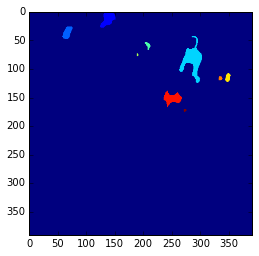

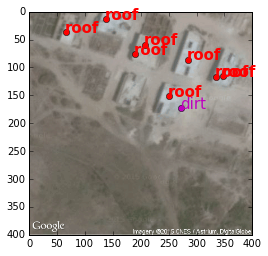

In [23]:
centroids, labels, probs = classify_image(image_fn, template_fn,
                                          image_data_fn, out_fn,
                                          use_color=True, use_hog=True,
                                          use_mag=True, thresh=0.05,
                                          color_rad=15, hog_rad=30,
                                          k=3, display=True)

That took forever!!! It looks like it works on the test image above though, so let's write a function to do batch classification.

In [24]:
import glob
import os
from time import time

In [25]:
# Specifying input and output image directories
in_dir = '../images/test_images/'
out_dir = '../images/output_images/'
template_fn = '../images/templates/template1.png'
image_data_fn = '../data/all_image_data.csv'

In [26]:
def batch_classify(in_dir, out_dir, template_fn, image_data_fn,
                   use_color=True, use_hog=True, use_mag=True,
                   thresh=0.05, color_rad=15, hog_rad=30, k=3):
    """
    This function classifies all images in the input directory and
    saves annotated output images in the output directory.
    :param in_dir: Input directory
    :param out_dir: Output directory
    :param template_fn: Path of template used to find candidates
    :param image_data_fn: Path of csv containing training data
    :param use_color: Use color histogram for classification
    :param use_hog: Use histogram of oriented gradients
    :param use_mag: Use gradient magnitudes
    :param thresh: Threshold value for template matching
    :param color_rad: Radius for computing color histogram
    :param hog_rad: Radius for computing hog features
    :param k: Number of neighbors for knn classifier
    """
    t_start = time()
    count = 0
    
    # Determine correct suffix
    if use_color and use_hog and use_mag:
        suffix = '_all'
    elif use_color and use_hog:
        suffix = '_color_hog'
    elif use_color and use_mag:
        suffix = '_color_mag'
    elif use_hog and use_mag:
        suffix = '_hog_mag'
    elif use_color:
        suffix = '_color'
    elif use_hog:
        suffix = '_hog'
    elif use_mag:
        suffix = '_mag'
    else:
        print 'Error: No features were specified.'
    
    # Process all images in input directory
    for image_fn in glob.glob(in_dir + '*'):
        out_fn = out_dir + str(count) + suffix + '.png'
        classify_image(image_fn, template_fn, image_data_fn, out_fn,
                       use_color, use_hog, use_mag, thresh, color_rad,
                       hog_rad, k)
        count += 1
    
    t_end = time()
    print 'Classified {} images in {} seconds.'.format(count,
                                                      (t_end - t_start))

In [27]:
# Batch classify all images in test images
batch_classify(in_dir, out_dir, template_fn, image_data_fn,
               use_color=False, use_hog=True, use_mag=False,
               thresh=0.05, color_rad=15, hog_rad=30, k=3)

Classified 10 images in 3.83093595505 seconds.


### Batch classify
Our batch classification seems to be working now... let's run it on the DHS images. I'm predicting that it'll take around 45 seconds since each image seems to take about a third of a second.

In [1]:
from classify import *

In [2]:
# Specifying input and output image directories
in_dir = '../images/DHS_in/'
out_dir = '../images/DHS_out/'
template_fn = '../images/templates/template1.png'
image_data_fn = '../data/all_image_data.csv'

In [6]:
# Batch classify all DHS images
batch_classify(in_dir, out_dir, template_fn, image_data_fn,
               use_color=True, use_hog=False, use_mag=False,
               thresh=0.05, color_rad=15, hog_rad=30, k=3)

Classified 136 images in 8.33936786652 seconds.


By simply training a knn classifier with all 3 types of features, we unfortunately don't achieve much better results than we did with the color histogram alone. However, one idea is to have the color histogram classify roofs alone first, then train another classifier using HOG or gradient magnitudes to separate out roofs from non-roofs. We can use the image patches identified as roofs by the color histograms as training examples for the next stage classifier.

## Classification pipeline
Instead of using color, hog, and gradient magnitude features to classify roof candidates, let's now develop a pipeline where the images are first classified using a color histogram classifer trained on the training samples. If the color histogram classifies the template candidates as roofs, then these will be the candidates for the next step of the process, which will use a HOG and gradient magnitude classifier to classify between roofs and non-roofs.

The first step is to get some training data: We will classify the DHS images using color histograms only, then output patches surrounding the candidates that are classified as roofs. These patches can be separated into true roofs and false roofs to train the HOG/gradient classifier. Also, if we want, we can use a true HOG feature vector now (with blocks and cells) instead of the simple HOG features that I wrote myself.

Let's use this next section to collect training examples from the DHS image set:

In [1]:
from classify import *
from utils import *
from features import *
import os
import glob
import cv2
import time

%matplotlib inline

In [2]:
# Specifying input and output image directories
in_dir = '../images/old/DHS_in/'
template_fn = '../images/templates/template1.png'
image_data_fn = '../data/all_image_data.csv'

In [3]:
# Rename DHS input images
out_dir = '../images/DHS_in/'
count = 0
t0 = time.time()
for image_fn in glob.glob(in_dir + '*'):
    image = cv2.imread(image_fn)
    image_fn_out = out_dir + str(count) + '.png'
    cv2.imwrite(image_fn_out, image)
    count += 1
t1 = time.time()
print 'Renaming {} images took {} seconds.'.format(count, (t1-t0))

Renaming 136 images took 4.75463604927 seconds.


In [3]:
# Specifying input image and output images
in_dir = '../images/DHS_in/'
count = 62
image_fn = in_dir + str(count) + '.png'
out_dir = '../images/hog/'
out_fn = out_dir + str(count) + '.png'

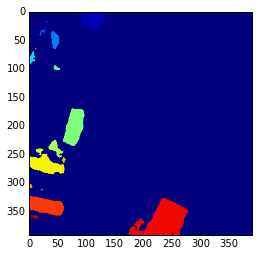

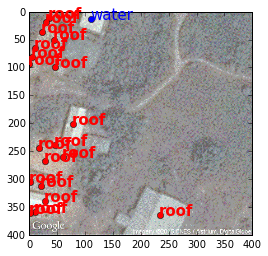

In [4]:
# Classify candidates found by template using color histogram only
(centroids, labels, probs) = classify_image(image_fn, template_fn,
                                            image_data_fn, out_fn,
                                            use_color=True,
                                            use_hog=False,
                                            use_mag=False, thresh=0.1,
                                            color_rad=15, hog_rad=30,
                                            k=5, display=False)

In [8]:
# For each candidate classified as a roof, save the image patch
image = cv2.imread(image_fn)
roof_count = 0
for i in range(0,len(centroids)):
    if labels[i] == 'roof':
        centroid = centroids[i]
        patch = get_image_patch(image, centroid, radius=30, best=False)
        if patch is not None:
            out_fn = out_dir + str(count) + '_' + str(roof_count) + '.png'
            cv2.imwrite(out_fn, patch)
        roof_count += 1

Ok, now let's do this for ALL of the DHS images at once:

In [10]:
# Specifying input image and output images
in_dir = '../images/DHS_in/'
out_dir = '../images/hog/'
count = 0
t0 = time.time()
for image_fn in glob.glob(in_dir + '*'):
    out_fn = out_dir + str(count) + '.png'
    # Classify candidates found by template using color histogram only
    (centroids, labels, probs) = classify_image(image_fn, template_fn,
                                            image_data_fn, out_fn,
                                            use_color=True,
                                            use_hog=False,
                                            use_mag=False, thresh=0.1,
                                            color_rad=15, hog_rad=30,
                                            k=5, display=False)
    if centroids is not None:
        # For each candidate classified as a roof, save the image patch
        image = cv2.imread(image_fn)
        roof_count = 0
        for i in range(0,len(centroids)):
            if labels[i] == 'roof':
                centroid = centroids[i]
                patch = get_image_patch(image, centroid, radius=30, best=False)
                if patch is not None:
                    out_fn = out_dir + str(count) + '_' + str(roof_count) + '.png'
                    cv2.imwrite(out_fn, patch)
                roof_count += 1
    count += 1
print 'Took {} seconds.'.format(time.time() - t0)

Took 10.8161761761 seconds.


In [12]:
# Rename nonroof training examples
in_dir = '../images/hog/roof/'
out_dir = '../images/hog/roof/'
count = 0
t0 = time.time()
for image_fn in glob.glob(in_dir + '*'):
    image = cv2.imread(image_fn)
    image_fn_out = out_dir + str(count) + '.png'
    cv2.imwrite(image_fn_out, image)
    count += 1
t1 = time.time()
print 'Renaming {} images took {} seconds.'.format(count, (t1-t0))

Renaming 63 images took 0.171282052994 seconds.


### Training a classifier using HOG training images
Now that we've collected some training examples, let's train a classifier using HOG and gradient magnitudes on this set of samples:

In [1]:
from classify import *
from utils import *
from features import *
import os
import glob
import cv2
import time

%matplotlib inline

In [2]:
# Get features from HOG training examples and save in csv
csv_out = '../data/hog_training_data.csv'
hog_dir = '../images/hog/'
store_image_data(hog_dir, csv_out)

Processed 63 images for roof class.
Processed 370 images for nonroof class.
Processed 433 images total in 21.1465380192 seconds.


In [27]:
# Import HOG training data
csv_in = '../data/hog_training_data.csv'
(features, colors, hogs, mags, labels, label_encoder) = \
            import_image_data(csv_in, display=False)
predictions = label_encoder.inverse_transform(labels)

#### PCA with just HOG features

In [91]:
from sklearn import decomposition

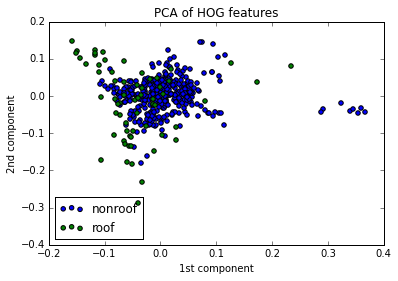

In [92]:
pca = decomposition.PCA(n_components=2)
pca.fit(hogs)
X_pca = pca.transform(hogs)
# Plot PCA decomposition with 2 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_pca[indices,0], X_pca[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='lower left')
plt.title('PCA of HOG features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

#### PCA with just gradient magnitude features

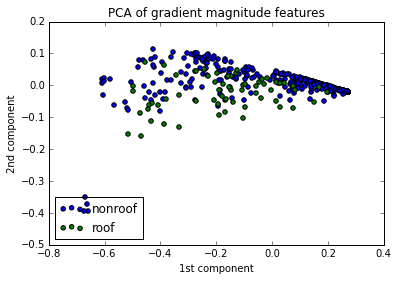

In [93]:
pca = decomposition.PCA(n_components=2)
pca.fit(mags)
X_pca = pca.transform(mags)
# Plot PCA decomposition with 2 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_pca[indices,0], X_pca[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='lower left')
plt.title('PCA of gradient magnitude features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

#### PCA with both gradient magnitude and HOG features

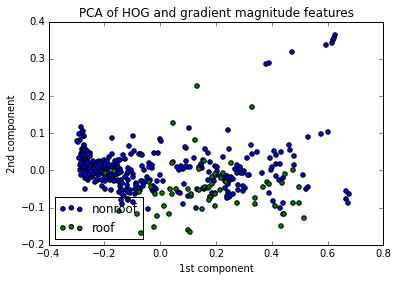

In [94]:
hog_mag = np.concatenate((hogs, mags), axis=1)
pca = decomposition.PCA(n_components=2)
pca.fit(hog_mag)
X_pca = pca.transform(hog_mag)
# Plot PCA decomposition with 2 classes 
plt.figure()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(np.unique(labels).size):
    indices = np.where(labels==i)
    plt.scatter(X_pca[indices,0], X_pca[indices,1], c=colors[i])
plt.legend([label_encoder.inverse_transform(i) for i in\
            range(np.unique(labels).size)], loc='lower left')
plt.title('PCA of HOG and gradient magnitude features')
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.show()

### Sample classification using KNN

In [95]:
from sklearn import neighbors

In [96]:
# Mix up the data
perm = np.random.permutation(labels.size)
hogs = hogs[perm]
mags = mags[perm]
hog_mag = hog_mag[perm]
labels = labels[perm]
n_neighbors = 3

#### HOG only

In [97]:
# Create and fit a nearest-neighbor classifier
knn1 = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Train on first 300 out of 433 observations
knn1.fit(hogs[:300], labels[:300])
# Test on observations 301-433
accuracy = knn1.score(hogs[300:], labels[300:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.954887218045


#### Gradient magnitudes only

In [98]:
# Create and fit a nearest-neighbor classifier
knn2 = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Train on first 300 out of 433 observations
knn2.fit(mags[:300], labels[:300])
# Test on observations 301-433
accuracy = knn2.score(mags[300:], labels[300:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.872180451128


#### HOG and gradient magnitudes

In [99]:
# Create and fit a nearest-neighbor classifier
knn3 = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
# Train on first 300 out of 433 observations
knn3.fit(hog_mag[:300], labels[:300])
# Test on observations 301-433
accuracy = knn3.score(hog_mag[300:], labels[300:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.924812030075


### Sample classification using linear SVM

In [100]:
from sklearn import svm

#### HOG only

In [101]:
svc1 = svm.SVC(kernel='linear')
# Train on first 300 out of 433 observations
svc1.fit(hogs[:300], labels[:300])
# Test on observations 301-433
accuracy = svc1.score(hogs[300:], labels[300:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.842105263158


#### Gradient magnitudes only

In [102]:
svc2 = svm.SVC(kernel='linear')
# Train on first 300 out of 433 observations
svc2.fit(mags[:300], labels[:300])
# Test on observations 301-433
accuracy = svc2.score(mags[300:], labels[300:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.842105263158


#### HOG and gradient magnitudes

In [103]:
svc3 = svm.SVC(kernel='linear')
# Train on first 300 out of 433 observations
svc3.fit(hog_mag[:300], labels[:300])
# Test on observations 301-433
accuracy = svc3.score(hog_mag[300:], labels[300:])
print 'Overall classification accuracy: {}'.format(accuracy)

Overall classification accuracy: 0.842105263158


## Two-step classification
Now we want to implement our new image classification pipeline with the following steps:
1. Identify roof candidates using template matching
2. Classify candidates using knn on color histograms
3. Candidates identified as roofs will be used as roof candidates for the next stage of classification
4. Classify candidates using knn on HOG and gradient magnitudes

In [7]:
from classify import *
from utils import *
from features import *
import os
import glob
import cv2
import time

%matplotlib inline

IndentationError: unindent does not match any outer indentation level (classify.py, line 248)

In [2]:
in_dir = '../images/DHS_in/'
out_dir = '../images/DHS_out/'
image_fn = in_dir + '62.png'
out_fn = out_dir + '62_two_step.png'
template_fn = '../images/templates/template1.png'
image_data_fn = '../data/all_image_data.csv'
hog_data_fn = '../data/hog_training_data.csv'

In [3]:
def hog_classify(image_fn, hog_data_fn, centroids, predictions, labels,
                 hog_rad=32, k=3):
    """
    This function classifies all candidate roofs found by the color
    histogram classifier. It returns the updated labels and predictions.
    :param image_fn: Path of input image
    :param hog_data_fn: Path of csv containing training data
    :param centroids: Candidate centroids
    :param predictions: Color histogram predictions [0-3]
    :param labels: Color histogram class labels
    :param hog_rad: Radius for computing hog features
    :param k: Number of neighbors for knn classifier
    :returns: Updated predictions [0-4] and class labels
    """
        
    # Get training data
    (train_data, train_labels, label_encoder) = \
                get_training_data(hog_data_fn, use_color=False,
                                  use_hog=True, use_mag=True)
    print train_data.shape

    # Get test data
    #test_data = get_test_data(image_fn, centroids, hog_rad, use_color=False,
    #                          use_hog=True, use_mag=True)
    # Load input image
    image = cv2.imread(image_fn)
    n = centroids.shape[0]
    bins_hog = 9
    bins_mag = 16
    test_data = np.zeros((n, bins_hog + bins_mag))
    for i in range(n):
        hog_data, mag_data = get_hog_vector(image, centroids[i,:],
                                           hog_rad)
        test_data[i,:] = np.concatenate((hog_data, mag_data),
                                        axis=1)

    # Classify candidates
    (hog_predictions, hog_labels, hog_probs) = classify_candidates(
                                 train_data, train_labels, test_data,
                                 label_encoder, k)
    
    # Update predictions and labels
    for i in range(predictions.shape[0]):
        if labels[i] == 'roof':
            if hog_labels[i] == 'nonroof':
                labels[i] = 'nonroof'
                predictions[i] = 4
    
    return (predictions, labels)

In [8]:
def two_step_classify_image(image_fn, template_fn, image_data_fn,
                   hog_data_fn, out_fn=None, thresh=0.05, color_rad=15,
                   hog_rad=32, k=3, display=False):
    """
    This function classifies all candidate roofs within an image and
    saves a labeled version of the original image. It first finds
    candidates using template matching and classifies those, then uses
    the candidates classified as roofs as new candidates for another
    round of classification. It returns the candidate centroid
    locations, predicted labels, and classification probabilities.
    :param image_fn: Path of input image
    :param template_fn: Path of template used to find candidates
    :param image_data_fn: Path of csv containing training data
    :param hog_data_fn: Path of csv containing hog training data
    :param out_fn: Path of output image
    :param thresh: Threshold value for template matching
    :param color_rad: Radius for computing color histogram
    :param hog_rad: Radius for computing hog features
    :param k: Number of neighbors for knn classifier
    :param display: Choose True to display plots
    :returns: Candidate centroids, predicted label, and classification
    probabilities
    """
    # Template match, threshold, and segment
    markers, num_markers = find_markers(image_fn, template_fn)
    if display:
        plt.figure()
        plt.imshow(markers)
        plt.show()

    # If at least one candidate is found
    if num_markers > 1:
        
        # Find centroids
        centroids = find_centroids(markers, num_markers)
        
        # Get training data
        (train_data, train_labels, label_encoder) = \
                    get_training_data(image_data_fn, use_color=True,
                                      use_hog=False, use_mag=False)
        
        # Get test data
        test_data = get_test_data(image_fn, centroids, use_color=True,
                                  use_hog=False, use_mag=False)
        
        # Classify candidates
        (predictions, labels, probs) = classify_candidates(train_data,
                                             train_labels, test_data,
                                             label_encoder, k)
        
        # Stage 2 classification
        # If nonroof, change prediction to 4, label to 'nonroof'
        (predictions, labels) = hog_classify(image_fn, hog_data_fn,
                                            centroids, predictions,
                                            labels, hog_rad, k)
        
        # Annotate and display candidate classification results
        image = annotate_results(image_fn, centroids, predictions,
                                 labels)
        
        # Display classification results
        if display:
            # Load image for display
            converted_image = Image.open(image_fn).convert('P')
            # Colors and weights for each class
            colors = ['m', 'r', 'g', 'b', 'c']
            weights = ['normal', 'bold', 'normal', 'normal', 'normal']
            # Annotate plot for display
            plt.figure()
            plt.imshow(converted_image)
            for i in range(centroids.shape[0]):
                plt.plot(centroids[i,1], centroids[i,0], 'o',
                         color=colors[predictions[i]])
                plt.text(centroids[i,1], centroids[i,0], labels[i],
                         color=colors[predictions[i]], fontsize=15,
                         fontweight=weights[predictions[i]])
            plt.xlim(0,400)
            plt.ylim(0,400)
            plt.gca().invert_yaxis()
            plt.show()
        
    # If no candidates are found
    else:
        centroids = None
        labels = None
        probs = None
        if display:
            # Load image for display
            converted_image = Image.open(image_fn).convert('P')
            plt.figure()
            plt.imshow(converted_image)
            plt.show()
        # Load input image
        image = cv2.imread(image_fn)
    
    # Write output image
    if out_fn is not None:
        cv2.imwrite(out_fn, image)
    
    return (centroids, labels, probs)

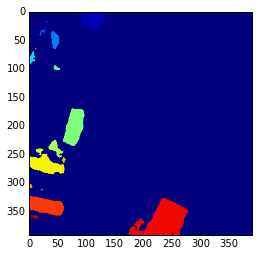

(433, 25)


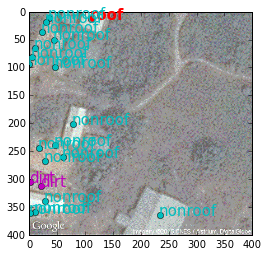

In [9]:
(centroids, labels, probs) = two_step_classify_image(image_fn,
                             template_fn, image_data_fn, hog_data_fn, 
                             out_fn=None, thresh=0.05, color_rad=15,
                             hog_rad=32, k=3, display=True)

In [6]:
centroids

NameError: name 'centroids' is not defined

In [7]:
labels

NameError: name 'labels' is not defined

In [14]:
probs

array([[ 0.        ,  0.66666667,  0.        ,  0.33333333],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.66666667,  0.        ,  0.33333333],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.66666667,  0.33333333,  0.        ,  0.        ],
       [ 0.66666667,  0.33333333,  0.        ,  0.        ],
       [ 0.        ,  1.